# Spatial Tx: ingest 10x Visium sample data
- Download sample data from https://cf.10xgenomics.com/samples/spatial-exp/2.1.0/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma
- Ingest into spatial SOMA
- Read from SOMA, inspect/plot data

In [1]:
from functools import partial
import numpy as np
from os import makedirs, remove
from os.path import basename, exists, join
import shlex
from shutil import rmtree
from subprocess import check_call
from sys import stderr
from urllib.parse import urlparse
err = partial(print, file=stderr)

from tiledbsoma.experimental import from_visium
from tiledbsoma import CompositeTransform, Experiment

[Papermill](https://papermill.readthedocs.io/en/latest/) parameters:

In [2]:
# 10x visium sample data paths to download; will be skipped if already present locally, unless `overwrite`
url_base = 'https://cf.10xgenomics.com/samples/spatial-exp/2.1.0'
dataset_name = 'CytAssist_FFPE_Protein_Expression_Human_Glioblastoma'
filtered_h5 = 'CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_filtered_feature_bc_matrix.h5'
spatial_tar = 'CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_spatial.tar.gz'

# Local download/ingestion paths/configs:
data_root = 'data'     # Sync 10x Visium spatial data into f"{data_root}/{dataset_name}/10x". By default, spatial SOMA data will be ingested into f"{data_root}/{dataset_name}/soma" as well.
exp_uri = None         # Ingest spatial SOMA data here; defaults to f"{data_root}/{dataset_name}/soma"
scene_name = "scene1"  # Scene name to write, in ingested spatial SOMA
overwrite_10x = False  # If  already exists, remove and re-ingest it
overwrite_exp = False  # If `exp_uri` already exists, remove and re-ingest it

In [3]:
# Set default paths
dataset_root = join(data_root, dataset_name)
data_dir_10x = join(dataset_root, '10x')
if exp_uri is None:
    exp_uri = join(dataset_root, 'soma')
exp_uri

'data/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/soma'

In [4]:
def sh(*cmd):
    err(f"Running: {shlex.join(cmd)}")
    check_call(cmd)    

### Download sample data from 10x

In [5]:
if exists(exp_uri):
    if overwrite_exp:
        err(f"Removing {exp_uri}")
        rmtree(exp_uri)

In [6]:
paths = {
    filtered_h5: 'filtered_feature_bc_matrix.h5',
    spatial_tar: spatial_tar
}
if exists(exp_uri):
    err(f"{exp_uri} exists; skipping 10x data download")
else:
    for src_name, dst_name in paths.items():
        src = f'{url_base}/{dataset_name}/{src_name}'
        dst = join(data_dir_10x, dst_name)
        if exists(dst):
            if overwrite_10x:
                err(f"{dst} exists, removing")
                remove(dst)
        if not exists(dst):
            makedirs(data_dir_10x, exist_ok=True)
            sh('wget', '-qO', dst, src)
            if dst.endswith('.tar.gz'):
                sh('tar', '-C', data_dir_10x, '-xvf', dst)

data/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/soma exists; skipping 10x data download


In [7]:
if not exists(exp_uri):
    err(f"Ingesting {data_dir_10x} to {exp_uri}")
    from_visium(
        exp_uri,
        input_path=data_dir_10x,
        measurement_name="RNA",
        scene_name=scene_name,
        use_raw_counts=False,
    )

In [8]:
exp = Experiment.open(exp_uri)
exp

<Experiment 'data/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/soma' (open for 'r') (3 items)
    'spatial': 'file:///home/julia/Software/TileDB-Inc/TileDB-SOMA/apis/python/notebooks/data/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/soma/spatial' (unopened)
    'obs': 'file:///home/julia/Software/TileDB-Inc/TileDB-SOMA/apis/python/notebooks/data/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/soma/obs' (unopened)
    'ms': 'file:///home/julia/Software/TileDB-Inc/TileDB-SOMA/apis/python/notebooks/data/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/soma/ms' (unopened)>

In [9]:
exp.spatial

<Collection 'file:///home/julia/Software/TileDB-Inc/TileDB-SOMA/apis/python/notebooks/data/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/soma/spatial' (open for 'r') (1 item)
    'scene1': 'file:///home/julia/Software/TileDB-Inc/TileDB-SOMA/apis/python/notebooks/data/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/soma/spatial/scene1' (unopened)>

In [10]:
scene = exp.spatial[scene_name]
scene

<Scene 'file:///home/julia/Software/TileDB-Inc/TileDB-SOMA/apis/python/notebooks/data/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/soma/spatial/scene1' (open for 'r') (3 items)
    'img': 'file:///home/julia/Software/TileDB-Inc/TileDB-SOMA/apis/python/notebooks/data/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/soma/spatial/scene1/img' (unopened)
    'obsl': 'file:///home/julia/Software/TileDB-Inc/TileDB-SOMA/apis/python/notebooks/data/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/soma/spatial/scene1/obsl' (unopened)
    'varl': 'file:///home/julia/Software/TileDB-Inc/TileDB-SOMA/apis/python/notebooks/data/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/soma/spatial/scene1/varl' (unopened)>

In [11]:
spots = scene.obsl['loc'].read().concat().to_pandas()
spots

,y,x,soma_joinid,obs_id,in_tissue,array_row,array_col,_soma_geometry
0,-87,3078,5436,TGCCACATAGCCGCAA-1,1,26,182,92.296927
1,17,680,1735,CATCAGGTAGGTGAAC-1,1,17,181,92.296927
2,28,1212,1410,ATTGATAACAGGATAG-1,1,19,181,92.296927
3,39,1745,1337,ATTAGAAGTGAACGAA-1,1,21,181,92.296927
4,165,411,166,AAGGTGGAAGCCACGC-1,1,16,180,92.296927
...,...,...,...,...,...,...,...,...
5751,22616,22038,4115,GTGAATTAGATTGTAA-1,1,99,37,92.296927
5752,22913,21500,5220,TCTAGCAATGCGATCA-1,1,97,35,92.296927
5753,23231,22026,5016,TCCGTCAAGTACAAGA-1,1,99,33,92.296927
5754,22638,23103,2766,CTGTCAATGGCTATTA-1,1,103,37,92.296927


In [12]:
obs_df = exp.obs.read().concat().to_pandas()
obs_df

,soma_joinid,obs_id
0,0,AACAATGGAACCACAT-1
1,1,AACAATGTGCTCCGAG-1
2,2,AACACCAGCCTACTCG-1
3,3,AACACCATTCGCATAC-1
4,4,AACACCGAATGTCTCA-1
...,...,...
5751,5751,TGTTGGCCTGTAGCGG-1
5752,5752,TGTTGGTGCGCACGAG-1
5753,5753,TGTTGGTGCGCTTCGC-1
5754,5754,TGTTGGTGCGGAATCA-1


In [13]:
joinid_counts = spots.soma_joinid.value_counts().value_counts()
assert len(joinid_counts) == 1
joinid_counts

count
1    5756
Name: count, dtype: int64

In [14]:
img = scene["img"]
img

<Collection 'file:///home/julia/Software/TileDB-Inc/TileDB-SOMA/apis/python/notebooks/data/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/soma/spatial/scene1/img' (open for 'r') (2 items)
    'hires': 'file:///home/julia/Software/TileDB-Inc/TileDB-SOMA/apis/python/notebooks/data/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/soma/spatial/scene1/img/hires' (unopened)
    'lowres': 'file:///home/julia/Software/TileDB-Inc/TileDB-SOMA/apis/python/notebooks/data/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/soma/spatial/scene1/img/lowres' (unopened)>

In [15]:
hires = img["hires"]
hires_uri = hires.uri

In [16]:
hires_scale = CompositeTransform.from_json(img.metadata["soma_asset_transform_hires"])
lores_scale = CompositeTransform.from_json(img.metadata["soma_asset_transform_lowres"])

In [17]:
im = hires.read().to_numpy()
im2 = im.transpose(1,2,0)

In [18]:
import matplotlib.patches as mplp
from matplotlib.collections import PatchCollection

scale = hires_scale[0].scale[1]
spot_patches = PatchCollection([
    mplp.Circle((row["y"] / scale, row["x"] / scale), radius = row["_soma_geometry"] / scale, fill=False, alpha=0)
    for _, row in spots.iterrows()
])

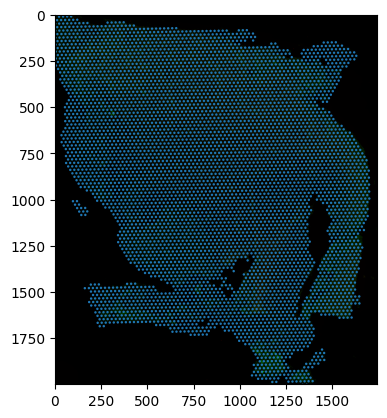

In [19]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.imshow(im2.astype(np.short), resample=None)
ax.add_collection(spot_patches)

plt.show()